In [11]:
#!/usr/bin/python
import sys
import pickle
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

# Task 1: 
Select what features you'll use.
features_list is a list of strings, each of which is a feature name.
The first feature must be "poi".

In [2]:
features_list = ['poi',
                 'bonus',
                 'deferral_payments',
                 'deferred_income',
                 'director_fees',
                 'exercised_stock_options',
                 'expenses',
                 'from_messages',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'loan_advances',
                 'long_term_incentive',
                 'other',
                 'relative_messages_from_poi',
                 'relative_messages_to_poi',
                 'restricted_stock',
                 'restricted_stock_deferred',
                 'salary',
                 'shared_receipt_with_poi',
                 'to_messages',
                 'total_payments',
                 'total_stock_value']

# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Task 2
Remove outliers / data preparation

In [3]:
outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']  # See notebook data exploration

for outlier in outliers:
    del data_dict[outlier]

# Task 3
Create new feature(s)

In [4]:
for employee in data_dict:
    to_messages = data_dict[employee]['to_messages']
    from_messages = data_dict[employee]['from_messages']
    from_poi_to_this_person = data_dict[employee]['from_poi_to_this_person']
    from_this_person_to_poi = data_dict[employee]['from_this_person_to_poi']

    # If either of the input features for the new feature is 'NaN',
    # the result for the new feature will also be 'NaN'
    if to_messages == 'NaN' or from_poi_to_this_person == 'NaN':
        data_dict[employee]['relative_messages_to_poi'] = 'NaN'
    if from_messages == 'NaN' or from_this_person_to_poi == 'NaN':
        data_dict[employee]['relative_messages_from_poi'] = 'NaN'

    # If both input features are not 'NaN', calculate the new features
    else:
        # Convert to float here, otherwise the check for 'NaN' above would not have worked correctly
        # (values would be the 'real' nan)
       
        to_messages = float(to_messages)
        from_messages = float(from_messages)
        from_poi_to_this_person = float(from_poi_to_this_person)
        from_this_person_to_poi = float(from_this_person_to_poi)

        # Calculate the new features
        data_dict[employee]['relative_messages_from_poi'] = from_poi_to_this_person/to_messages
        data_dict[employee]['relative_messages_to_poi'] = from_this_person_to_poi/from_messages

In [5]:
# Store to my_dataset for easy export below.
my_dataset = data_dict

In [6]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list)

In [7]:
labels, features = targetFeatureSplit(data)

I'll use a somewhat adapted version of the cross-validator in `tester.py` to check what combination of features performs best. See below:

In [12]:
def test_classifier(clf, features, labels, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv:
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append(features[ii])
            labels_train.append(labels[ii])
        for jj in test_idx:
            features_test.append(features[jj])
            labels_test.append(labels[jj])

        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
        #print clf.best_params_
        jasper += 1
        clear_output(wait=True)
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)

        return {'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'f2': f2}
    except:
        return {'value': 'undefined'}

In [14]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [ ]:
result_dict = {}

for k in range(1, len(features_list)):
    print k
    selector = SelectKBest(f_classif, k=k).fit(features, labels)
    best_features = SelectKBest(f_classif, k=k).fit_transform(features, labels)        

    result_dict[k] = test_classifier(clf, best_features, labels, folds = 1000)
    
    i_feature_name = selector.get_support(indices=True)
    feature_names = [features_list[1:][i] for i in i_feature_name]
    result_dict[k]['feature_names'] = feature_names
    
    clear_output(wait=True)

In [16]:
df_result = pd.DataFrame.from_dict(result_dict, orient='index')

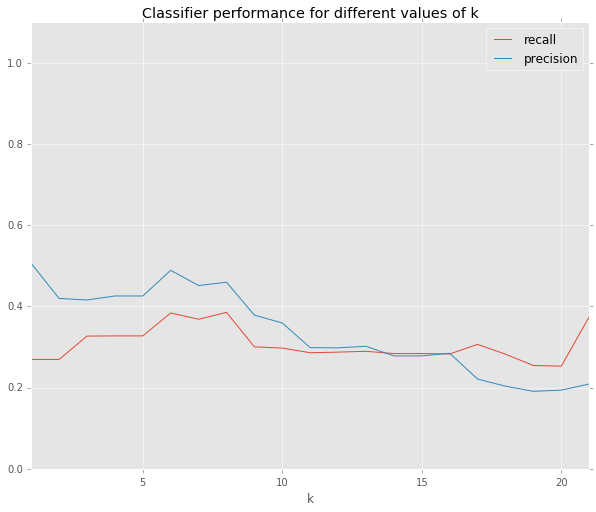

In [17]:
ax = df_result[['recall', 'precision']].plot(title='Classifier performance for different values of k', figsize=(10,8), ylim=[0,1.1])
ax.set_xlabel('k')

In [18]:
feature_names = df_result.loc[6]['feature_names']

features_idx = [features_list.index(feature)-1 for feature in feature_names]

Check what feature scores belongs to which feature

In [19]:
features_idx

[0, 2, 4, 13, 16, 20]

In [20]:
selector = SelectKBest(f_classif, k=6).fit(features, labels)
print selector.scores_[features_idx]
print feature_names

[ 20.79225205  11.45847658  24.81507973  16.40971255  18.28968404
  24.18289868]
['bonus', 'deferred_income', 'exercised_stock_options', 'relative_messages_to_poi', 'salary', 'total_stock_value']
